In [1]:
import numpy as np
import mnist_loader as ml
import matplotlib.pyplot as plt
from matplotlib import style

In [3]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 120
# style.use('seaborn-v0_8')
style.use('seaborn')

In [4]:
training_data, validation_data, test_data = ml.load_data_wrapper()

In [5]:
a, b = zip(*training_data)
c, d = zip(*validation_data)
e, f = zip(*test_data)

a = np.array([x.reshape(784,) for x in a])
c = np.array([x.reshape(784,) for x in c])
e = np.array([x.reshape(784,) for x in e])

trainX = np.concatenate((a, c))
trainX = np.concatenate((np.ones([trainX.shape[0], 1]), trainX), axis=1)

b = np.array([y.reshape(10, ) for y in b])
cat = np.zeros([len(d), 10])
for i, y in enumerate(d):
    cat[i][y] = 1
d = cat

trainY = np.concatenate((b, d))

testX = np.concatenate((np.ones([e.shape[0], 1]), e), axis=1)

cat = np.zeros([len(d), 10])
for i, y in enumerate(f):
    cat[i][y] = 1
testY = cat

In [6]:
print(f'trainX: {trainX.shape}')
print(f'trainY: {trainY.shape}')
print(f'testX: {testX.shape}')
print(f'testY: {testY.shape}')

trainX: (60000, 785)
trainY: (60000, 10)
testX: (10000, 785)
testY: (10000, 10)


In [29]:
class Network:

    def __init__(self, sizes, activations, epochs=10, lr=0.1, batch=0):
        self.sizes = sizes
        self.activations = activations
        self.epochs = epochs
        self.lr = lr
        self.batch = batch
        self.weights = self.initWeights()

    def initWeights(self):
        weights = [0]*(len(self.sizes)-1)
        for layer in range(len(self.sizes)-1):
            m = self.sizes[layer] + 1
            n = self.sizes[layer + 1]
            weights[layer] = np.random.uniform(low=-1, high=1, size=(m, n)) * np.sqrt(6 / (m+n)) # xavier initialization
        return weights
    
    def activ(self, x, activation):

        if activation == 'sigmoid':
            return 1/(1+np.exp(-x))
        
        elif activation == 'relu':
            return np.maximum(0, x)
        
        elif activation == 'softmax':
            e_x = np.exp(x - np.max(x, axis=1, keepdims=True)) # subtract max for numerical stability, keepdims for correct broadcasting
            return (e_x / e_x.sum(axis=1)[:,None]) # sum along axis 1, because each row is a different observation; reshaping for correct broadcasting!
        
    def dactiv(self, x, activation):

        if activation == 'sigmoid':
            return self.activ(x, 'sigmoid') * (1 - self.activ(x, 'sigmoid'))
        
        elif activation == 'relu':
            return np.where(x >= 0, 1, 0)
        
    def forwardPass(self, X):

        M = X.shape[0]
        nLayers = len(self.sizes)

        Xs = [0]*nLayers
        Xs[0] = X
        nets = [0]*(nLayers-1)

        for layer in range(1, nLayers-1):
            activation = self.activations[layer-1]
            nets[layer-1] = Xs[layer-1] @ self.weights[layer-1] 
            Xs[layer] = np.concatenate((np.ones([M,1]), self.activ(nets[layer-1], activation)), axis=1)

        nets[-1] = Xs[-2] @ self.weights[-1]
        activation = self.activations[-1]
        Xs[-1] = self.activ(nets[-1], activation) # for last layers we don't concatenate with column of ones

        return Xs, nets
    
    def backPropagation(self, X, Y):

        M = X.shape[0]
        nLayers = len(self.sizes)
        Xs, nets = self.forwardPass(X)

        dLdX = [0]*(nLayers-1)

        dLdX[-1] = Xs[-1] - Y
        for i in range(nLayers-3, -1, -1):
            activation = self.activations[i]
            dLdX[i] = dLdX[i+1] @ self.weights[i+1][1:].T * self.dactiv(nets[i], activation)

        dLdW = [(dLdX[i].T @ Xs[i]) / M for i in range(len(dLdX))]

        new_weights = [self.weights[i] - self.lr * dLdW[i].T for i in range(len(dLdW))]
        self.weights = new_weights
    
    def accuracyAndCost(self, X, Y):

        Xs = self.forwardPass(X)[0]
        last = Xs[-1]
        M = X.shape[0]
        yPred = np.argmax(last, axis=1)
        yReal = np.argmax(Y, axis=1)
        return np.mean(yPred == yReal), np.sum(-Y * np.log(last) - (1-Y) * np.log(1-last)) / M

    def shuffleData(self, xTrain, yTrain):

        data = np.concatenate((xTrain, yTrain), axis=1)
        np.random.shuffle(data)
        xTrain = data[: ,0:785]
        yTrain = data[:, 785:]

        return xTrain, yTrain        

    def train(self, xTrain, yTrain):

        M = xTrain.shape[0]
        Js = [0]*self.epochs

        for epoch in range(self.epochs):
            slicer = np.array([0, self.batch])

            for i in range(M // self.batch): 
                batch = slicer + i*self.batch
                self.backPropagation(xTrain[batch[0]:batch[1]], yTrain[batch[0]:batch[1]])

            accTrain, J = self.accuracyAndCost(xTrain, yTrain)
            Js[epoch] = J
            xTrain, yTrain = self.shuffleData(xTrain, yTrain)

            print(f'Epoch: {epoch+1}; Train set accuracy: {accTrain}')

        return Js

    def predict(self, xTest, yTest):

        Xs = self.forwardPass(xTest)[0]
        last = Xs[-1]
        yPred = np.argmax(last, axis=1)
        yReal = np.argmax(yTest, axis=1)
        print(f'Test set accuracy: {np.mean(yPred == yReal)}')

        return yPred


In [32]:
N = Network([784, 150, 70, 10], ['sigmoid', 'relu', 'softmax'], epochs=100, lr=0.1, batch=100)

In [33]:
cost = N.train(trainX, trainY)

Epoch: 1; Train set accuracy: 0.8781833333333333
Epoch: 2; Train set accuracy: 0.9122666666666667
Epoch: 3; Train set accuracy: 0.9216666666666666
Epoch: 4; Train set accuracy: 0.929
Epoch: 5; Train set accuracy: 0.9338833333333333
Epoch: 6; Train set accuracy: 0.9381166666666667
Epoch: 7; Train set accuracy: 0.9455
Epoch: 8; Train set accuracy: 0.9514166666666667
Epoch: 9; Train set accuracy: 0.9504666666666667
Epoch: 10; Train set accuracy: 0.9582666666666667
Epoch: 11; Train set accuracy: 0.9592833333333334
Epoch: 12; Train set accuracy: 0.9616166666666667
Epoch: 13; Train set accuracy: 0.96515
Epoch: 14; Train set accuracy: 0.9662
Epoch: 15; Train set accuracy: 0.9666333333333333
Epoch: 16; Train set accuracy: 0.9712833333333334
Epoch: 17; Train set accuracy: 0.9722166666666666
Epoch: 18; Train set accuracy: 0.9734833333333334
Epoch: 19; Train set accuracy: 0.9749666666666666
Epoch: 20; Train set accuracy: 0.9768833333333333
Epoch: 21; Train set accuracy: 0.9763666666666667
Epoch: 

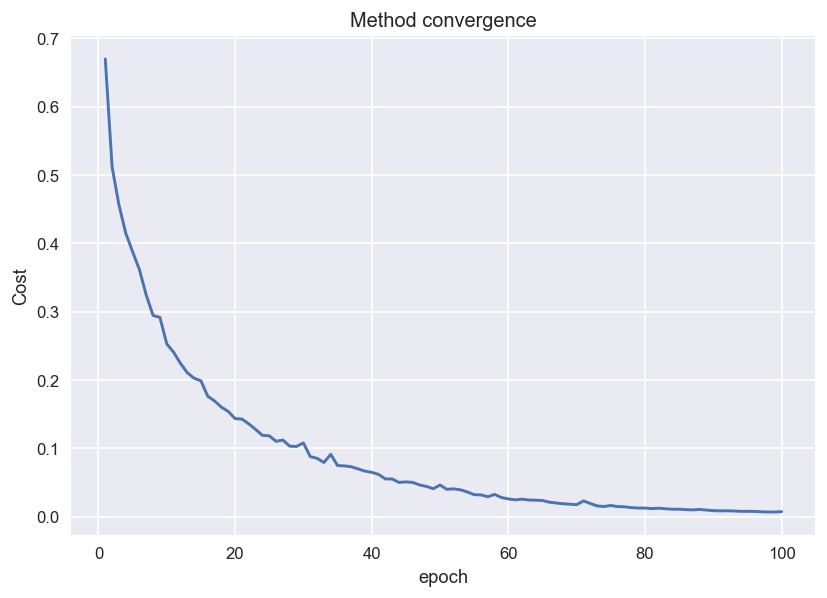

In [34]:
plt.plot(list(range(1, 101)), cost)
plt.title('Method convergence')
plt.xlabel('epoch')
plt.ylabel('Cost')
plt.show()

In [35]:
predictions = N.predict(testX, testY)

Test set accuracy: 0.9792


In [36]:
N2 = Network([784, 150, 70, 10], ['sigmoid', 'relu', 'softmax'], epochs=10, lr=0.1, batch=100)

In [37]:
cost2 = N2.train(trainX, trainY)

Epoch: 1; Train set accuracy: 0.874
Epoch: 2; Train set accuracy: 0.9107
Epoch: 3; Train set accuracy: 0.92045
Epoch: 4; Train set accuracy: 0.9264666666666667
Epoch: 5; Train set accuracy: 0.9356166666666667
Epoch: 6; Train set accuracy: 0.9366333333333333
Epoch: 7; Train set accuracy: 0.9470166666666666
Epoch: 8; Train set accuracy: 0.94745
Epoch: 9; Train set accuracy: 0.95315
Epoch: 10; Train set accuracy: 0.9534166666666667


In [38]:
predictions = N2.predict(testX, testY)

Test set accuracy: 0.9513


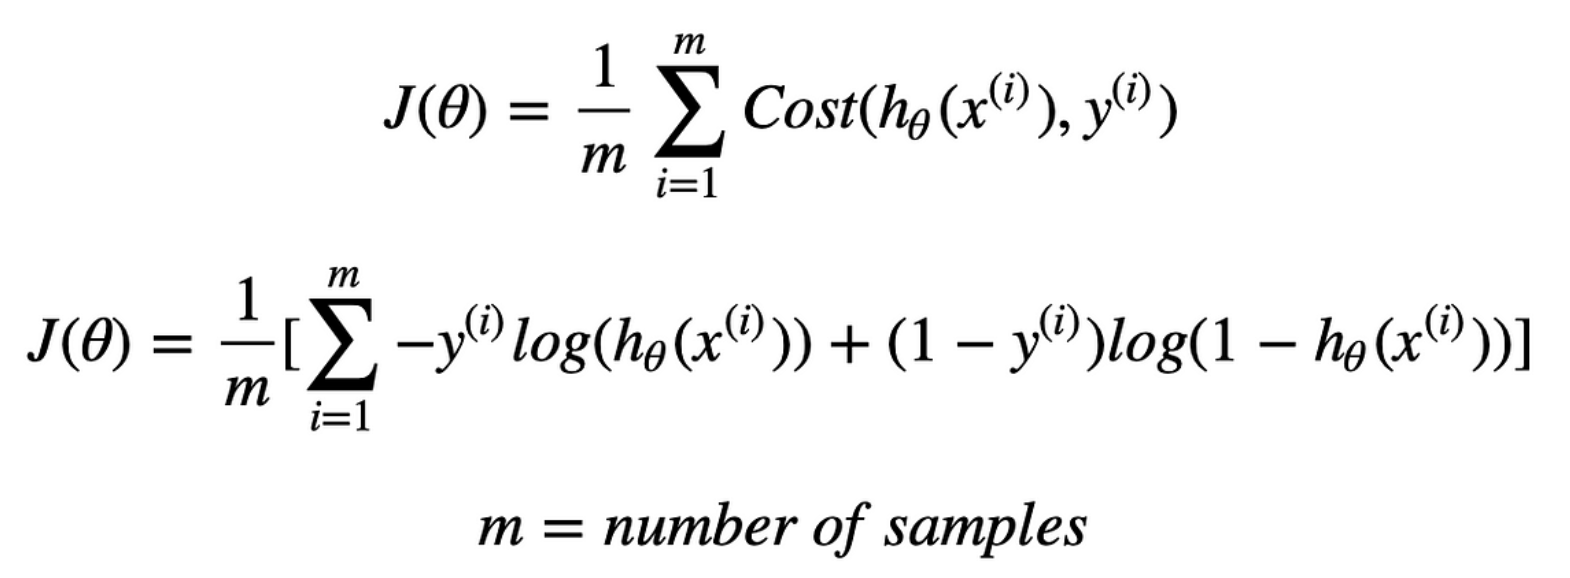